In [ ]:
# This file is to simulate Surface code Based D-CNOT.
# Because QEC (e.g., 3-distance Surface code) requires too many qubits (50 qubits) and quantum gates (252 q-gates) in theory, qiskit will consume huge memory, computing resources, and time if simulated according to theory. If we do so, an error will appear: "A circuit requires more memory than max_memory_mb." Therefore, we use approximate simulation to implement Surface code with distance 3 for comparison.

# Key design points for approximate simulation: 
# 1, D-CNOT implemented with an error correction circuit of 2-data qubits is used to approximate the D-CNOT circuit of 2 groups of 13-data qubits Surface code (as we mentioned in the paper). 
# 2, In the approximate simulation, the first data qubit, q1, represents the original data qubit before Surface code encoding. The second qubit, q2, represents the rest of the data qubits.
# 3, In the approximate simulation, the first data qubit has an error correction q-gate, which approximates the ability of error correction for single-qubit errors in Surface code(distance = 3). On the contrary, the second data qubit has no error correction circuit, which approximates that the Surface code (distance=3) can not resist multi-qubit errors.
# 4, In theory, we take two groups of 13-data qubit Surface codes to form logical entanglement for D-CNOT. However, in approximate simulations, we directly use q1q2 for D-CNOT. Their effects are similar for the following reasons:
#     a) q1q2 is entangled.
#     b) In the approximate simulation, we can use the case that errors simultaneously happened in q1 and q2 to represent that the surface code is not resistant to multi-qubit errors, causing D-CNOT to fail. This effect is approximately equivalent to the simultaneous occurrence of multi-qubit errors causing D-CNOT to fail in two groups of 13-data qubit Surface codes.
#     c) The circuit's design and the experimental results show that our approximate simulation can fully reflect the theoretical case's result (two groups of 13-bit Surface codes).

In [4]:
# This code cell is to define the circuit of Surface code Based D-CNOT. You can visualize the circuit by "circuit.draw("mpl")".
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from numpy import pi
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
    phase_amplitude_damping_error,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
import numpy as np
import random

qreg_q = QuantumRegister(6, 'q')
creg_c0 = ClassicalRegister(1, 'c0')
creg_c1 = ClassicalRegister(1, 'c1')
creg_c2 = ClassicalRegister(1, 'c2')
creg_c3 = ClassicalRegister(1, 'c3')
circuit = QuantumCircuit(qreg_q, creg_c0, creg_c1, creg_c2, creg_c3)

circuit.h(qreg_q[1])
circuit.h(qreg_q[3])
circuit.h(qreg_q[4])
circuit.cx(qreg_q[1], qreg_q[2])
circuit.cx(qreg_q[3], qreg_q[1])
circuit.cx(qreg_q[3], qreg_q[2])
circuit.cz(qreg_q[4], qreg_q[1])
circuit.cz(qreg_q[4], qreg_q[2])
circuit.h(qreg_q[3])
circuit.h(qreg_q[4])
circuit.measure(qreg_q[3], creg_c0[0])
circuit.measure(qreg_q[4], creg_c1[0])
circuit.z(qreg_q[1]).c_if(creg_c0, 1)
circuit.x(qreg_q[1]).c_if(creg_c1, 1)
circuit.h(qreg_q[0])
circuit.cx(qreg_q[0], qreg_q[1])
circuit.measure(qreg_q[1], creg_c2[0])
circuit.x(qreg_q[2]).c_if(creg_c2, 1)
circuit.cx(qreg_q[2], qreg_q[5])
circuit.h(qreg_q[2])
circuit.measure(qreg_q[2], creg_c3[0])
circuit.z(qreg_q[0]).c_if(creg_c3, 1)
circuit.measure_all()
#circuit.draw("mpl")

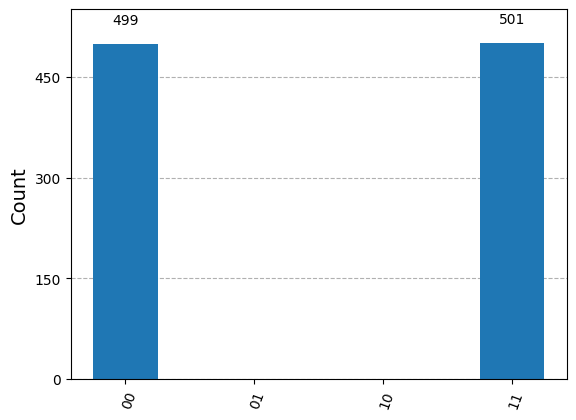

In [5]:
# This code cell is to perform the ideal simulation (without noise).
# Repeatedly exec circuit for 1000 times.
# The result shows the probability of case:00 + case:11 is 100% which means that the control_qubit is totally related to target_qubit. (D-CNOT's success rate is 100%)
# If case:00 + case:11 is not 100% which means control_qubit is not totally related to target_qubit. (D-CNOT's success rate is not 100%.)
# Especially, if case:00 +case:11 is only 50% which means control_qubit is not realated to target_qubit. (D-CNOT's success rate is 0%.)

sim_ideal = AerSimulator()
counts = sim_ideal.run(circuit,shots=1000).result().get_counts()
target_qubits_counts = {'00': 0, '01': 0,'10': 0,'11': 0}
for outcome, count in counts.items():
    target_qubits = outcome[5]+outcome[0]  # choose q0(outcome[5]) and q5(outcome[0])
    target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)

/Users/ben/Library/Python/3.8/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


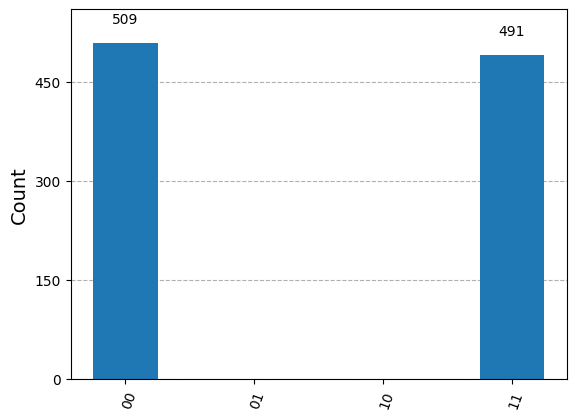

In [3]:
# This code cell is to simulate realistic case (with noise)(one qubit is totally decoherent because of noise, while other qubits are perfect) (Corresponding to the case of one entanglement is totally decoherent, while other entanglements are perfect in EE Based D-CNOT.)
# The result shows the success rate of D-CNOT is 100%, which means Surface code based D-CNOT can tolerant one qubit error.

p_depo_1 = 1  # depolarizing error probability
p_depo_2 = 0

# QuantumError objects
depol_noise_q1 = depolarizing_error(p_depo_1, 2)
depol_noise_q2 = depolarizing_error(p_depo_2, 1)


# Create noisy simulator backend
noise_set = NoiseModel()
noise_set.add_quantum_error(depol_noise_q1, ['cx'], [1,2])
noise_set.add_quantum_error(depol_noise_q2, ['h'], [2])
sim_noise = AerSimulator(noise_model=noise_set)

# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
circuit_tnoise = passmanager.run(circuit)

#Run and get counts
counts = sim_noise.run(circuit_tnoise,shots=1000).result().get_counts()
target_qubits_counts = {'00': 0, '01': 0,'10': 0,'11': 0}
for outcome, count in counts.items():
    target_qubits = outcome[5]+outcome[0]  # choose q0(outcome[5]) and q5(outcome[0])
    target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)

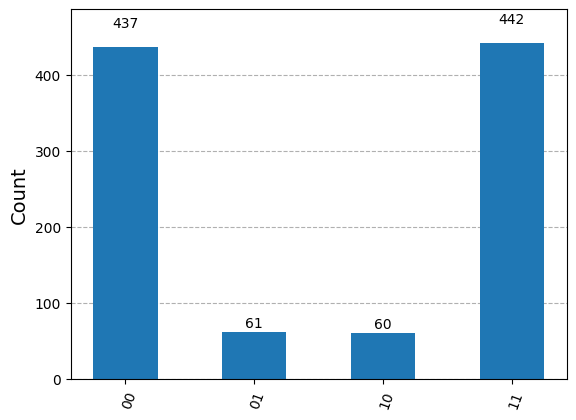

In [25]:
# This code cell is to simulate realistic case (with noise)(one qubit is totally decoherent because of noise, while other qubits may suffer the same level noise)(Corresponding to the case of one entanglement is totally decoherent, while other entanglements are also suffered noise in EE Based D-CNOT.)
# When the perturbed qubit is not a neighbor of the total decoherence qubit, it will not lead to an error in the D-CNOT's result because the Surface code is resistant to multiple non-adjacent qubits errors.
# When the perturbed qubit is a neighbor of the total decoherence qubit, it will lead to an error in the D-CNOT's result because the Surface code is not resistant to multiple adjacent qubits errors.
# You can adjust depo_rate to control the noise level.

target_qubits_counts = {'00': 0, '01': 0,'10': 0,'11': 0}
p_depo_1 = 1  # depolarizing error probability for q1
depo_rate = 0.2 # depolarizing error probability for q2

for i in range(1000):
    weights = [8/12, 1-(8/12)]
    choices = [depo_rate, 0]
    result_depo = random.choices(choices, weights=weights, k=1)[0]
    p_depo_2 = result_depo
    # QuantumError objects
    depol_noise_q1 = depolarizing_error(p_depo_1, 2)
    depol_noise_q2 = depolarizing_error(p_depo_2, 1)


    # Create noisy simulator backend
    noise_set = NoiseModel()
    noise_set.add_quantum_error(depol_noise_q1, ['cx'], [1,2])
    noise_set.add_quantum_error(depol_noise_q2, ['h'], [2])
    sim_noise = AerSimulator(noise_model=noise_set)

    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    circuit_tnoise = passmanager.run(circuit)

    #Run and get counts
    counts = sim_noise.run(circuit_tnoise,shots=1).result().get_counts()
    for outcome, count in counts.items():
        target_qubits = outcome[5]+outcome[0]  # choose q0(outcome[5]) and q5(outcome[0])
        target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)

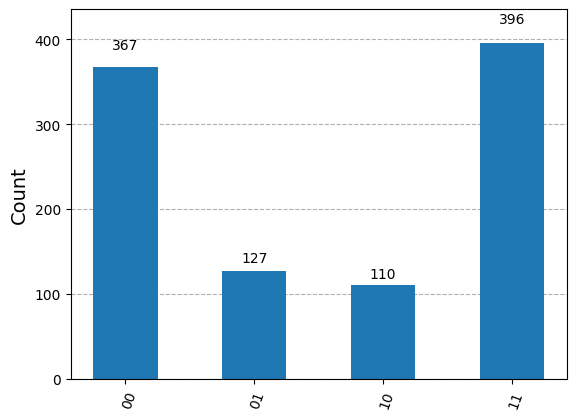

In [17]:
# This code cell is to simulate realistic case (with noise) (several qubits are suffered same level of noise)(Corresponding to the case of all entanglement are suffered the same level of noise in EE Based D-CNOT.)
# When the perturbed qubits are not adjacent, it will not lead to an error in the D-CNOT's result because the Surface code is resistant to multiple non-adjacent qubits errors.
# When the perturbed qubits are adjacent, it will lead to an error in the D-CNOT's result because the Surface code is not resistant to multiple adjacent qubits errors.

target_qubits_counts = {'00': 0, '01': 0,'10': 0,'11': 0}
depo_rate = 0.7 # depolarizing error probability for q1 and q2

for i in range(1000):
    weights = [(8/12)*(11/13), 1-((8/12)*(11/13))]
    choices = [depo_rate, 0]
    result_depo = random.choices(choices, weights=weights, k=1)[0]
    p_depo_1 = result_depo
    p_depo_2 = result_depo
    # QuantumError objects
    depol_noise_q1 = depolarizing_error(p_depo_1, 2)
    depol_noise_q2 = depolarizing_error(p_depo_2, 1)


    # Create noisy simulator backend
    noise_set = NoiseModel()
    noise_set.add_quantum_error(depol_noise_q1, ['cx'], [1,2])
    noise_set.add_quantum_error(depol_noise_q2, ['h'], [2])
    sim_noise = AerSimulator(noise_model=noise_set)

    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(optimization_level=3, backend=sim_noise)
    circuit_tnoise = passmanager.run(circuit)

    #Run and get counts
    counts = sim_noise.run(circuit_tnoise,shots=1).result().get_counts()
    for outcome, count in counts.items():
        target_qubits = outcome[5]+outcome[0]  # choose q0(outcome[5]) and q5(outcome[0])
        target_qubits_counts[target_qubits] += count
plot_histogram(target_qubits_counts)